In [1]:
import pandas as pd
import pandahouse
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
import swifter
from scipy import stats
%matplotlib inline

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20241020',
'user':'student',
'password':'dpo_python_2020'
}

In [17]:
q = """
SELECT user_id, exp_group, SUM(action = 'like') AS likes, SUM(action = 'view') AS views, likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2024-09-27' AND toDate(time) <= '2024-10-03' AND exp_group BETWEEN 1 AND 2
GROUP BY user_id, exp_group
"""

In [18]:
df = pandahouse.read_clickhouse(q, connection=connection)

<Axes: xlabel='ctr', ylabel='Count'>

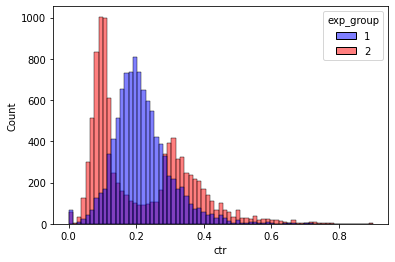

In [19]:
sns.histplot(df, x = df.ctr, hue = df.exp_group, palette=['b', 'r'])

Визуально два распределения очень различаются.

1. t-test

In [20]:
ttest = stats.ttest_ind(df[df['exp_group'] == 1]['ctr'], df[df['exp_group'] == 2]['ctr'], equal_var=False)

In [21]:
ttest

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Тест Стьюдента показывает, что разница между средними CTR двух групп различаются статистически незначимо.

Тест Манна-Уитни

In [22]:
stats.mannwhitneyu(df[df['exp_group'] == 1]['ctr'], df[df['exp_group'] == 2]['ctr'], alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Тест Манна-Утни увидел разницу между распределениями CTR в двух группах.
Тест Стьюдента сработал некорректно в данном случае, так как одним из желательных условий его применения является нормальность данных (унимодальное распределение). Распределение в группе 2 значительно отличается от нормального (бимодальное). Использование же теста Манна-Уитни не привязывается к типу распределения, и его чувствительность в данном случае выше.

Сглаженный CTR

In [25]:
def get_smothed_ctr(likes, views, g_ctr, alpha):
    smothed_ctr = (likes + alpha * g_ctr) / (views + alpha)
    return smothed_ctr

In [27]:
g_ctr_1 = df[df['exp_group'] == 1].likes.sum() / df[df['exp_group'] == 1].views.sum()
g_ctr_2 = df[df['exp_group'] == 2].likes.sum() / df[df['exp_group'] == 2].views.sum()

In [29]:
gr_1 = df[df.exp_group == 1].copy()
gr_2 = df[df.exp_group == 2].copy()

In [32]:
gr_1['sm_ctr'] = df.apply(lambda x: get_smothed_ctr(x.likes, x.views, g_ctr_1, 5), axis = 1)

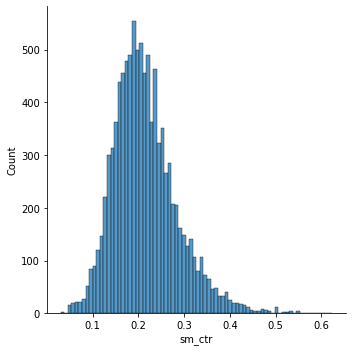

In [35]:
sns.displot(gr_1.sm_ctr)

In [36]:
gr_2['sm_ctr'] = df.apply(lambda x: get_smothed_ctr(x.likes, x.views, g_ctr_2, 5), axis = 1)

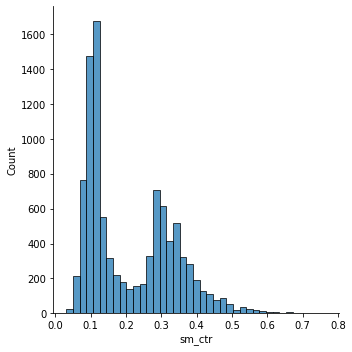

In [37]:
sns.displot(gr_2.sm_ctr)

In [38]:
stats.mannwhitneyu(gr_1['sm_ctr'], gr_2['sm_ctr'], alternative = 'two-sided')

MannwhitneyuResult(statistic=55528353.0, pvalue=2.396534039374286e-50)

Тест Манна-Уитни снова также увидел разницу в распределениях.

Bootstrap

In [39]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [40]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [41]:
ctr_1, ctr_2 = bootstrap(likes1, views1, likes2, views2)

<Axes: ylabel='Count'>

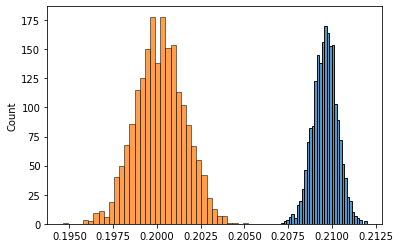

In [42]:
sns.histplot(ctr_1)
sns.histplot(ctr_2)

Данный метод показал статистичеки значимую разницу между CTR двух групп.

Ситуация, когда появляется две моды в группе 2, может быть связана с неоднозначным эффектом вводимого изменения на две разные группы пользователей, например, мужчин и женщин или пользователей iOS и Android (может быть какой-то баг) и т.д.

Новый алгоритм все же не стоит раскатывать на всех пользователей, так как он оказал в большинстве своем отрицательный эффект (падение CTR где-то на 5 %) на довольно таки большую группу пользователей, несмотря на некоторое значительное улучшение для другой части пользователей второй группы. Результаты bootstrap подтверждают предположение, что суммарный эффект изменения алкогоритма все-таки отрицательный.

<Axes: ylabel='Count'>

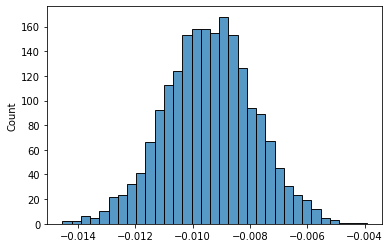

In [44]:
sns.histplot(ctr_2 - ctr_1)